# Model Prototype

### This notebook shows how to create a baseline model pipeline and save it

##### We save the Spark Dataframe as an Iceberg Table. Iceberg is a new open table format backed by Apple, Netflix and Cloudera. 
##### In the context of ML Ops, the most anticipated feature is Time Travel i.e. the ability to reproduce the data and the schema across different versions in time
##### Finally, we create a simple PySpark pipeline and train a classifier with Keras/Tensorflow

* For a more comprehensive demo of Iceberg in CML, please visit the [Spark3 Iceberg CML Github Repository](https://github.com/pdefusco/Spark3_Iceberg_CML)
* For a more detailed introduction to CML Session, Notebooks, and Spark tips and trips please visit the [CML Total Beginner GitHub Repository](https://github.com/pdefusco/CML-Total-Beginner)
* For a more comprehensive example of the Atlas Python client mentioned below, please visit the [Atlas Client Example Notebook in the Data Integration with ML GitHub Repository](https://github.com/pdefusco/Data_Integration_wMachineLearning/blob/main/2_A_Atlas_Client_Example.ipynb)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from sklearn.datasets import make_circles
import tensorflow as tf
import pandas as pd
import seaborn as sns
from utils.plot_decision_boundary import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### The Spark Session is created with the following configurations. If you get an error, ensure your CML Session is using Runtimes and Spark 3.1.

In [3]:
spark = SparkSession.builder.master('local[*]')\
  .config("spark.jars.packages","org.apache.iceberg:iceberg-spark3-runtime:0.12.1")\
  .config("spark.sql.extensions","org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")\
  .config("spark.sql.catalog.spark_catalog","org.apache.iceberg.spark.SparkSessionCatalog")\
  .config("spark.sql.catalog.spark_catalog.type","hive")\
  .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
  .config("spark.yarn.access.hadoopFileSystems","s3a://gd01-uat2/")\
  .getOrCreate()

#### Loading the data...

In [64]:
# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv('data/LoanStats_2015_subset_120321.csv',   
    header=True,
    sep=',',
    nullValue='NA')

#### Investigating Target Class Imbalance

In [65]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|              null|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
+------------------+



In [66]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|12949|
|           Default|    1|
|              null|    2|
|   In Grace Period|  310|
|       Charged Off| 4880|
|Late (31-120 days)|  581|
|           Current|16767|
| Late (16-30 days)|   88|
+------------------+-----+

None


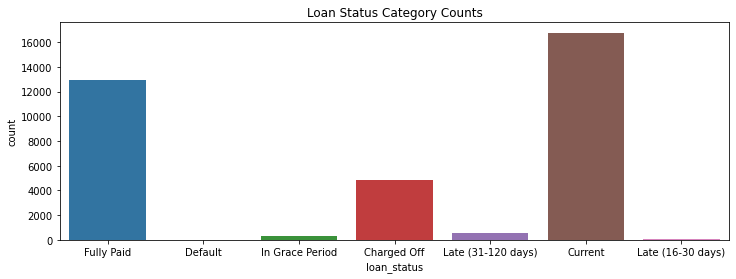

In [67]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(12,4))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

We want to predict Default vs Non-Default Loan Applicants...

#### Creating the Target Feature

In [68]:
df = df.withColumn("label", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

We start with a baseline...  we decide to start with only a few key features.

In [69]:
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'label'])
df = df.dropna()

#### Let's create a simple Baseline Model Pipeline

In [70]:
train = df.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10)

In [71]:
test = df.subtract(train)

In [72]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [73]:
from handyspark import *

In [74]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):        
     
    for c in spark_df.columns:
        spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=100, regParam=0.001, elasticNetParam=0.001)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [75]:
pipelineModel = make_pipeline(train)

In [84]:
def cols_to_float(df):
    for c in df.columns:
        df = df.withColumn(c, df[c].cast("float"))
    return df

In [87]:
test = cols_to_float(test)
clf_out_df = pipelineModel.transform(test)

In [88]:
clf_out_df.select("label", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7177|
|       1.0|    5|
+----------+-----+



In [89]:
clf_out_df.select("label", "prediction").groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  971|
|  0.0| 6211|
+-----+-----+



In [90]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(clf_out_df, scoreCol='probability', labelCol='label')

/home/cdsw/.local/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


/home/cdsw/.local/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


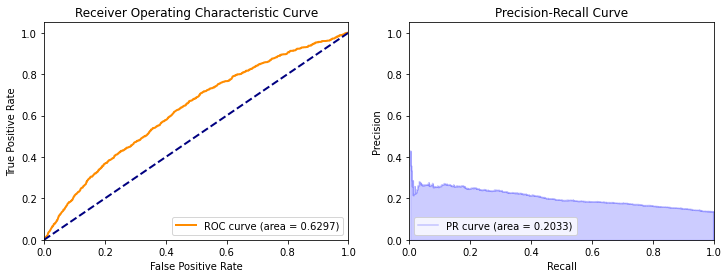

In [91]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [92]:
def get_confusion_matrix(spark_df):

    input_data = spark_df.rdd.map(lambda x: (x["label"], x["prediction"], float(x["probability"][1])))
    predictions = spark.createDataFrame(input_data, ["label", "prediction", "probability"])

    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()

    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_true, y_pred))
    cf_matrix = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    
    import seaborn as sns
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      6211
         1.0       0.60      0.00      0.01       971

    accuracy                           0.86      7182
   macro avg       0.73      0.50      0.47      7182
weighted avg       0.83      0.86      0.80      7182



Exception ignored in: <function JavaModelWrapper.__del__ at 0x7f46e425db90>
Traceback (most recent call last):
  File "/home/cdsw/.local/lib/python3.7/site-packages/pyspark/mllib/common.py", line 137, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'


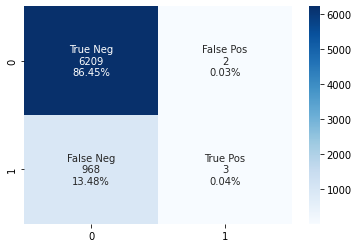

In [93]:
get_confusion_matrix(clf_out_df)

#### Time to train the classifier on the original data and deploy our scoring pipeline with CML Jobs

#### We will store the classifier locally. Keep in mind it could also be stored in S3 as shown below. 

In [117]:
def score_data(df):
    
    #Scoring on the entire dataset now
    df = cols_to_float(df)
    pipelineModel = make_pipeline(df)
    scored_df = pipelineModel.transform(df)
    scored_df = scored_df.select("acc_now_delinq", "acc_open_past_24mths", "annual_inc", "avg_cur_bal", "funded_amnt", "label")

    return scored_df, pipelineModel

In [118]:
scored_df, pipelineModel = score_data(df)

In [119]:
#This is a sample of what we will save to the datawarehouse
scored_df.show(4)

+--------------+--------------------+----------+-----------+-----------+-----+
|acc_now_delinq|acc_open_past_24mths|annual_inc|avg_cur_bal|funded_amnt|label|
+--------------+--------------------+----------+-----------+-----------+-----+
|           0.0|                 8.0|   65000.0|    10086.0|    12000.0|  0.0|
|           0.0|                 1.0|  150000.0|    61551.0|    25000.0|  0.0|
|           0.0|                 8.0|   75000.0|     7176.0|    28000.0|  0.0|
|           0.0|                 7.0|  175000.0|    51015.0|    30000.0|  0.0|
+--------------+--------------------+----------+-----------+-----------+-----+
only showing top 4 rows



### We can save the Scored Dataset into an Iceberg Table

### Notice that we retrained the model on the original dataset with the actual label. But we will create a new table replacing the label with the prediction. That is because our goal will be to score the model with fresh data, when it becomes available.

#### For the time being we will store the original labels in the prediction column. 

In [124]:
# Saving the Spark Dataframe as an Iceberg table
spark.sql("CREATE TABLE IF NOT EXISTS ice_cml (acc_now_delinq float, acc_open_past_24mths float, annual_inc float, avg_cur_bal float, funded_amnt float, prediction int) USING iceberg")

Py4JError: An error occurred while calling o60.sql. Trace:
py4j.Py4JException: Method format([class java.lang.String]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)



In [122]:
scored_df = scored_df.withColumnRenamed('label', 'prediction')

In [123]:
scored_df.write.format("iceberg").mode("overwrite").save("default.ice_cml")

Py4JError: An error occurred while calling o4897.format. Trace:
py4j.Py4JException: Method write([]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)



#### The table is automatically tracked by the Data Lake associated with the CML Workspace

#### To check that a new entry for the table has been added to Atlas in the Data Lake, go back to the CDP Homepage and open Data Catalog. 

#### Select the Data Lake (i.e. Cloud Environment) that your worskpace was built in. 

![title](img/cml_terminal.png)

#### Use the Atlas Search bar at the top to browse for the table and click on it

#### Notice Atlas is tracking a lot of interesting Metadata including Table Attributes, Lineage, and a lot More. 

#### The Metadata can even be customized. [This notebook](https://github.com/pdefusco/Data_Integration_wMachineLearning/blob/main/2_A_Atlas_Client_Example.ipynb) shows how you can use the Atlas Python Client to build custom lineage flows.

#### Back to Modeling. We will use Keras and Tensorflow to build this classifier. Our data is in Spark though, so we will use Petastorm to transform the data Tensorflow-readable.

In [13]:
!pip3 install petastorm

     |████████████████████████████████| 283 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 92.6 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 113.5 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 101.0 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 451 kB/s s eta 0:00:01
     |████████████████████████████████| 25.6 MB 116.3 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 880 kB/s s eta 0:00:01
     |████████████████████████████    | 246.9 MB 96.6 MB/s eta 0:00:011

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 281.3 MB 34 kB/s 
     |████████████████████████████████| 198 kB 110.8 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=32fda17f62ac6e87eaef8a6e235595e4c7024d506fdcc3aaba3a14d39688e0fc
  Stored in directory: /home/cdsw/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=1b9e3b29a52b66939ba7f5befa8ff94dbd56c39dcfbe7b8fc7924fe89509f65e
  Stored in directory: /home/cdsw/.cache/pip/wheels/e8/d9/e5/78436a0a3899d81410aeb45b200153113667f2e250f6882ada
Successfully built future pyspark


In [14]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
import tensorflow.compat.v1 as tf  # pylint: disable=import-error

In [21]:
# specify a cache dir first.

# Set a cache directory for intermediate data.
# The path should be accessible by both Spark workers and driver.
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF,"file:///tmp/petastorm/cache/tf-example")

In [ ]:
#!pip3 install s3fs

In [23]:
# create a converter from `df`
# it will materialize `df` to cache dir.
converter = make_spark_converter(sparkDF)

Converting floating-point columns to float32
The median size 5033 B (< 50 MB) of the parquet files is too small. Total size: 10062 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///tmp/petastorm/cache/tf-example/20211203233933-appid-local-1638570042715-2c963542-b1cd-4cd6-8bf5-1297cbb97040/part-00000-db00b0de-8eba-40c6-8675-01b28dff976b-c000.parquet, ...


In [ ]:
converter

In [24]:
# Create the model (same as model_7)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

In [27]:
# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

In [28]:
# make a tensorflow dataset from `converter`
with converter.make_tf_dataset() as dataset:
    # the `dataset` is `tf.data.Dataset` object
    # we can train/evaluate model on the `dataset`
    history = model.fit(dataset)
    # when exiting the context, the reader of the dataset will be closed
    
    # Evaluate our model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Model loss on the test set: {loss}")
    print(f"Model accuracy on the test set: {100*accuracy:.2f}%")


# delete the cached files of the dataframe.
converter.delete()

 727007/Unknown - 626s 859us/step - loss: -1534.6987 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:


# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);


# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples in the training set, 200 examples in the test set

# Set random seed
tf.random.set_seed(42)

# Create the model (same as model_7)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=25)

# Evaluate our model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X=X_test, y=y_test)
plt.show()

# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves")


model.save('models/my_model.h5')